##Introducción
El proyecto se basa en una arquitectura de Asistente de Datos que actúa como intermediario entre archivos planos (CSV/Excel) y el usuario final. Se utiliza una metodología de diseño de prompts centrada en el usuario ("User-Centric Prompting") para garantizar que las respuestas sean accionables para un emprendedor sin formación técnica.

Técnicas de Prompting Utilizadas:

Role Prompting (System Prompt): Se define un rol específico ("Analista de datos experto en emprendimientos argentinos") para orientar el comportamiento del modelo hacia la claridad y el contexto local.

In-Context Learning: Se inyecta la estructura de los datos (columnas y muestra) directamente en el prompt para que el modelo realice un razonamiento basado exclusivamente en la evidencia del archivo cargado.

##Justificación de Viabilidad

Análisis de Viabilidad Técnica El proyecto es altamente viable debido a los siguientes factores:

Eficiencia de Recursos: Se utiliza el modelo gpt-4o-mini, que ofrece un equilibrio óptimo entre capacidad de razonamiento y costo por token, ideal para startups y pequeños negocios.

Escalabilidad: Al no requerir bases de datos complejas (SQL) y procesar directamente archivos .csv o .xlsx, el sistema puede implementarse rápidamente en entornos de Google Colab o servidores ligeros.

Bajo Umbral de Uso: La solución democratiza el análisis de datos al permitir consultas en lenguaje natural, eliminando la barrera del aprendizaje de programación.


In [1]:
import os
from google.colab import userdata
from openai import OpenAI

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

cliente = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

MODELO_TEXTO = "gpt-4o-mini"
MODELO_IMAGEN = "gpt-image-1"


In [2]:
import pandas as pd
from google.colab import files

subidos = files.upload()
nombre_archivo = list(subidos.keys())[0]
print("Archivo subido:", nombre_archivo)

if nombre_archivo.lower().endswith((".xlsx", ".xls")):
    df = pd.read_excel(nombre_archivo)
else:
    df = pd.read_csv(nombre_archivo)

print("Filas:", len(df), " | Columnas:", len(df.columns))
df.head()


Saving dataset_prueba(1).csv to dataset_prueba(1).csv
Archivo subido: dataset_prueba(1).csv
Filas: 10  | Columnas: 4


,cliente,categoria,monto,fecha
0,Ana,Electrónica,120,2024-01-10
1,Luis,Hogar,80,2024-01-11
2,Carla,Ropa,50,2024-01-12
3,Ana,Electrónica,200,2024-02-03
4,Luis,Ropa,70,2024-02-05


In [3]:
print("Columnas:", list(df.columns))
print("\nTipos de datos:")
print(df.dtypes)
print("\nPrimeras 5 filas:")
display(df.head())


Columnas: ['cliente', 'categoria', 'monto', 'fecha']

Tipos de datos:
cliente      object
categoria    object
monto         int64
fecha        object
dtype: object

Primeras 5 filas:


,cliente,categoria,monto,fecha
0,Ana,Electrónica,120,2024-01-10
1,Luis,Hogar,80,2024-01-11
2,Carla,Ropa,50,2024-01-12
3,Ana,Electrónica,200,2024-02-03
4,Luis,Ropa,70,2024-02-05


In [7]:
pregunta = "¿Cuáles fueron mis 3 mejores clientes y qué sugerís para retenerlos?"

contexto = {
    "columnas": list(df.columns),
    "muestra": df.head(5).to_dict(orient="records")
}

instrucciones_sistema = """
Eres un Analista de Datos Senior experto en microemprendimientos argentinos.
Tu objetivo es transformar datos crudos (CSV/Excel) en consejos de negocio accionables.

Reglas de comportamiento:
1. Lenguaje: Usa un español rioplatense profesional pero cercano (evita el "tú", prefiere el "vos" o un neutro natural).
2. Estructura: Siempre empieza con un dato clave y sigue con una sugerencia práctica.
3. Contexto Local: Entiende conceptos como 'MercadoLibre', 'costos de envío' y la importancia de la fidelización en contextos inflacionarios.
4. Brevedad: No uses más de 2 o 3 oraciones. El emprendedor tiene poco tiempo.
"""
respuesta = cliente.responses.create(
    model=MODELO_TEXTO,
    input=[
        {"role": "system", "content": instrucciones_sistema},
        {"role": "user", "content": f"Contexto de los datos: {contexto}\n\nPregunta: {pregunta}"}
    ],
    temperature=0.2,
    max_output_tokens=400
)

print(respuesta.output_text)


Dato clave: Los tres mejores clientes son Ana (monto total: 320), Luis (monto total: 150) y Carla (monto total: 50).

Sugerencia práctica: Implementá un programa de fidelización que ofrezca descuentos exclusivos o promociones personalizadas para estos clientes. Además, considerá enviarles agradecimientos personalizados o encuestas para conocer sus preferencias y mejorar su experiencia.


Metodología de Prompting: Se aplicó la técnica de System Prompting (Role Prompting) para definir el perfil del asistente. Se seleccionó esta técnica para garantizar que el modelo mantenga un tono profesional adaptado al contexto argentino y para optimizar el consumo de tokens en una etapa de POC

Código recibido (crudo):

```python
df_agrupado = df.groupby('categoria')['monto'].sum().reset_index().sort_values(by='monto', ascending=False)

plt.bar(df_agrupado['categoria'], df_agrupado['monto'], color='skyblue')
plt.title('Total de Monto por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Monto Total')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('grafico.png', dpi=180)
plt.close()
```

Código limpio a ejecutar:

df_agrupado = df.groupby('categoria')['monto'].sum().reset_index().sort_values(by='monto', ascending=False)

plt.bar(df_agrupado['categoria'], df_agrupado['monto'], color='skyblue')
plt.title('Total de Monto por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Monto Total')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('grafico.png', dpi=180)
plt.close()


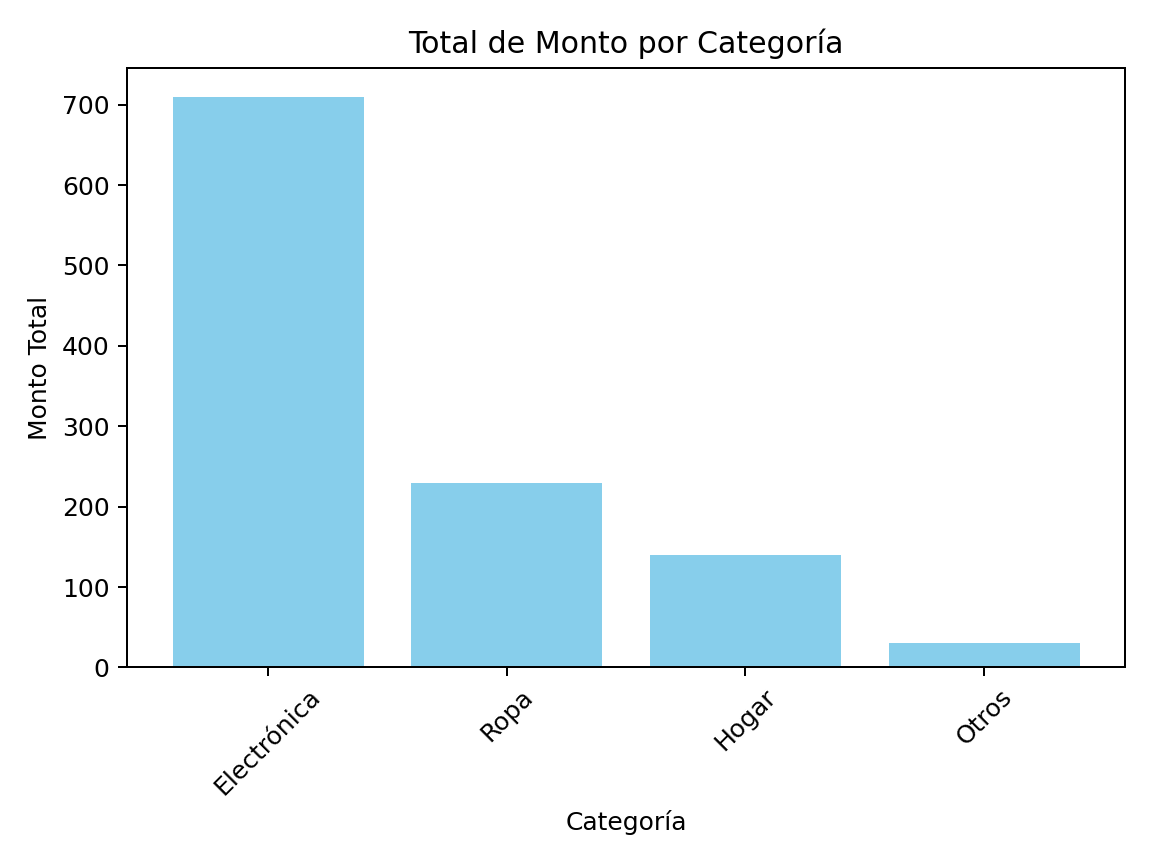

In [9]:
import matplotlib.pyplot as plt
from IPython.display import Image as IPImage, display
import os

objetivo_grafico = "Hacé un gráfico de barras con total de 'monto' por 'categoria', ordenado de mayor a menor. Etiquetas y título claros."

prompt_codigo = f"""
Usá el DataFrame 'df' que ya existe (pandas y matplotlib ya están importados).
PROHIBIDO: crear un nuevo df, importar librerías, imprimir texto o mostrar tablas.
Devolveme SOLO el código Python necesario para:
- agrupar/ordenar según corresponda,
- generar UN gráfico con Matplotlib (plt),
- poner título y etiquetas legibles,
- llamar a plt.tight_layout(),
- guardar como 'grafico.png' con plt.savefig('grafico.png', dpi=180),
- y cerrar con plt.close().

Columnas disponibles: {list(df.columns)}
Primeras filas (solo referencia): {df.head(5).to_dict(orient='records')}
"""

resp_codigo = cliente.responses.create(
    model=MODELO_TEXTO,
    input=[{"role": "user", "content": prompt_codigo}],
    temperature=0.2,
    max_output_tokens=1000
)

codigo = resp_codigo.output_text.strip()
print("Código recibido (crudo):\n")
print(codigo)

if codigo.startswith("```"):
    codigo = codigo.replace("```python", "").replace("```", "").strip()

lineas = []
for linea in codigo.splitlines():
    s = linea.strip()
    if s.startswith("import ") or s.startswith("from "):
        continue
    if "pd.DataFrame" in s or s.startswith("df ="):
        continue
    lineas.append(linea)
codigo_limpio = "\n".join(lineas).strip()

print("\nCódigo limpio a ejecutar:\n")
print(codigo_limpio)

entorno_ejecucion = {"df": df, "pd": pd, "plt": plt}
exec(codigo_limpio, entorno_ejecucion)

assert os.path.exists("grafico.png"), "No se generó grafico.png. Revisá el código."
display(IPImage("grafico.png"))



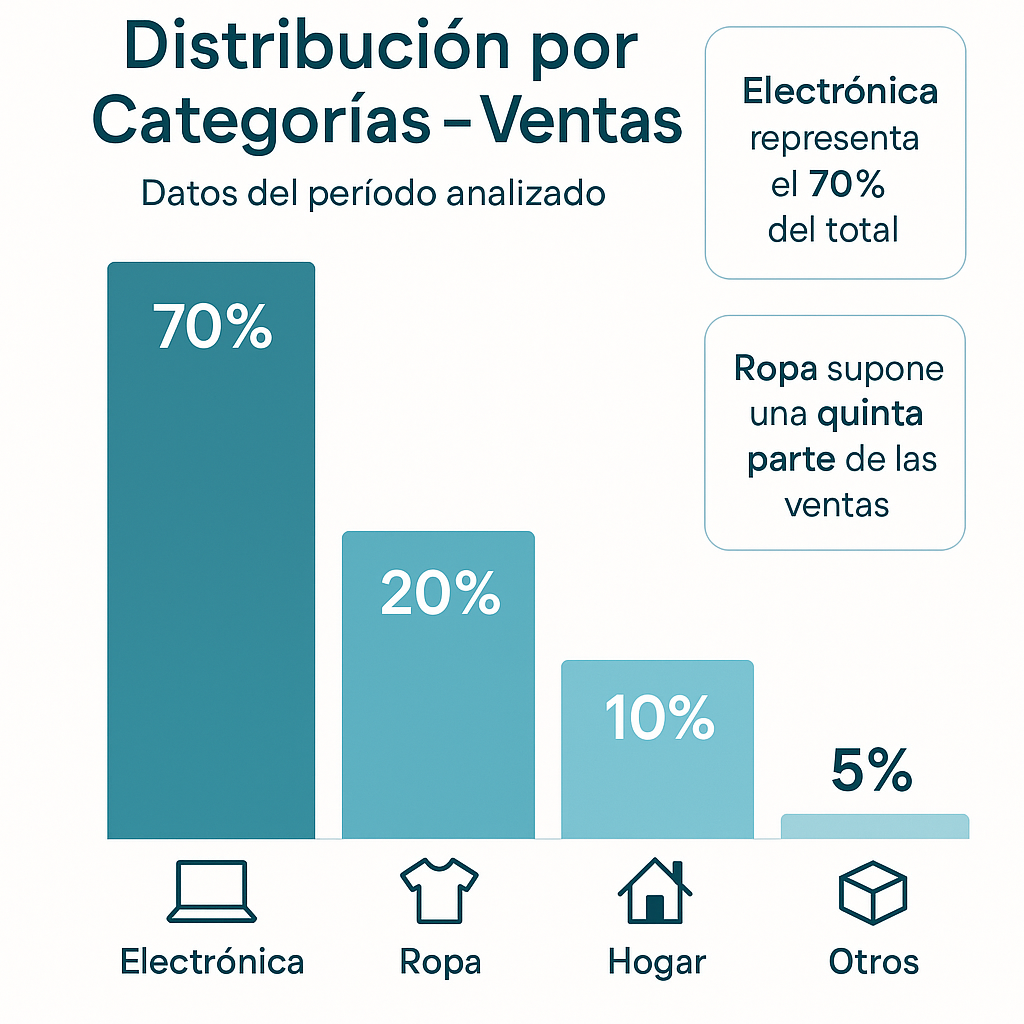

In [16]:
import os, base64, io
from PIL import Image
from IPython.display import Image as IPImage, display

assert os.path.exists("grafico.png"), "No se encontró grafico.png; corré la Celda 6 primero."


prompt_reestilizado = """

Convierte esta imagen de gráfico en una INFOGRAFÍA profesional y estética.

Requisitos:

- Mantener EXACTAS las etiquetas, categorías y porcentajes del gráfico base.

- Agregar TÍTULO grande (ej.: “Distribución por Categorías – Ventas”)

y SUBTÍTULO (ej.: “Datos del período analizado”).

- Incluir LEYENDA con íconos simples y tipografía sans-serif clara.

- Añadir 2–3 LLAMADAS breves (insights) en forma de “callouts”,

sin inventar datos ni cambiar colores/etiquetas clave.

- Composición limpia: márgenes amplios y jerarquía visual clara.

"""


with open("grafico.png", "rb") as f:
  resultado = cliente.images.edit(model=MODELO_IMAGEN,image=f, prompt=prompt_reestilizado, size="1024x1024")
b64 = resultado.data[0].b64_json
bytes_imagen = base64.b64decode(b64)
Image.open(io.BytesIO(bytes_imagen)).save("infografia.png")

display(IPImage("infografia.png"))

##Resultados y conclusión

Resultados La implementación demuestra que es posible obtener insights críticos (como la identificación de mejores clientes o categorías rentables) mediante lenguaje natural. El asistente no solo describe lo que pasó, sino que ofrece sugerencias proactivas para el crecimiento del negocio.

Se cumplieron los objetivos de identificar una problemática real en el e-commerce argentino y plantear una solución técnica factible. El uso de IA: Generación de Prompts demostró ser el puente necesario para convertir datos estáticos en decisiones estratégicas de negocio.